In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(progress_bar=True, nb_workers=multiprocessing.cpu_count())

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def break_and_compare(ls, k):
    n = len(ls)
    while n % k != 0:
        n -= 1
    to_break = ls[:n]
    residual = ls[n:]
    chunk_size = n // k
    while len(residual) < chunk_size:
        # split into chunks
        chunks = [to_break[i:i + chunk_size] for i in range(0, len(to_break), chunk_size)]
        chunksMatch = True
        # compare all chunks to first chunk
        for chunk in chunks[1:]:
            if chunk != chunks[0]:
                chunksMatch = False
                break
        if chunksMatch:
            # compare residual to first chunk
            if residual == chunks[0][:len(residual)]:
                return chunks[0]
        chunk_size -= 1
        new_residual = to_break[chunk_size * k:]
        to_break = to_break[:chunk_size * k]
        residual = new_residual + residual
    return []

In [3]:
def break_and_compare_wrapper(ls, start_k, end_k):
    # end_k is inclusive
    ls = list(ls)
    for k in range(start_k, end_k + 1):
        result = break_and_compare(ls, k)
        if result:
            return result, k
    return [], -1

In [4]:
break_and_compare([1,2,3,4,1,2,3,4,1,2,3,4,1], k=3)

[1, 2, 3, 4]

In [5]:
break_and_compare_wrapper([1,2,3,4,1,2,3,4,1,2,3,4,1], start_k=2, end_k=4)

([1, 2, 3, 4], 3)

In [16]:
files = os.listdir('../data')
# choose files without 'lrs' or 'mrs' in the name
files = [file for file in files if 'lrs' not in file and 'mrs' not in file and 'chunk' not in file]
files.remove('exact_match_ratios.csv')
files

['pythia-70m.pkl',
 'pythia-160m.pkl',
 'pythia-410m.pkl',
 'pythia-1b.pkl',
 'pythia-1.4b.pkl',
 'pythia-2.8b.pkl',
 'pythia-6.9b.pkl',
 'pythia-70m-deduped.pkl',
 'pythia-160m-deduped.pkl',
 'pythia-410m-deduped.pkl',
 'pythia-1b-deduped.pkl',
 'pythia-1.4b-deduped.pkl',
 'pythia-2.8b-deduped.pkl',
 'pythia-6.9b-deduped.pkl']

In [7]:
def get_df_with_chunk_and_k(file):
    df = pickle.load(open('../data/' + file, 'rb'))
    df['chunk'], df['k'] = zip(*df['tokens'].parallel_apply(break_and_compare_wrapper, args=(2, 10)))
    # save df as pickle
    pickle.dump(df, open('../data/' + file + "_with_chunk_and_k", 'wb'))
    return df
    

In [8]:
def load_df_with_chunk_and_k(file):
    return pickle.load(open('../data/' + file + "_with_chunk_and_k", 'rb'))

In [9]:
df = load_df_with_chunk_and_k(files[0])

In [10]:
def plot_chunk_length(file):
    df = load_df_with_chunk_and_k(file)
    df_without_k_negative_1 = df[df['k'] != -1]
    # bar plot of df_without_k_negative_1['k'] and save
    plt.figure(figsize=(10, 5))
    sns.countplot(x='k', data=df_without_k_negative_1)
    plt.title('Distribution of k for ' + file)
    plt.savefig('../plots/' + file + '_chunk_length.png')
    # plt.show()

In [11]:
# for file in files:
#     print(file)
#     get_df_with_chunk_and_k(file)

In [12]:
# for file in files:
#     print(file)
#     plot_chunk_length(file)

In [14]:
files

['pythia-70m.pkl',
 'pythia-160m.pkl',
 'pythia-410m.pkl',
 'pythia-1b.pkl',
 'pythia-1.4b.pkl',
 'pythia-2.8b.pkl',
 'pythia-6.9b.pkl',
 'pythia-70m-deduped.pkl',
 'pythia-160m-deduped.pkl',
 'pythia-410m-deduped.pkl',
 'pythia-1b-deduped.pkl',
 'pythia-1.4b-deduped.pkl',
 'pythia-2.8b-deduped.pkl',
 'pythia-6.9b-deduped.pkl',
 'exact_match_ratios.csv']

In [18]:
# df_ratios = pd.DataFrame(columns=['file', 'ratio_2_3', 'ratio_2_total', 'ratio_3_total', 'ratio_not_memorized_total', 
#                                   'count_2', 'count_3', 'count_not_memorized', 'count_total'])
# for file in files:
#     df = load_df_with_chunk_and_k(file)
#     k_dist = df['k'].value_counts().to_dict()
#     ratio_2_3 = k_dist[2]/k_dist[3]
#     ratio_2_total = k_dist[2]/sum(k_dist.values())
#     ratio_3_total = k_dist[3]/sum(k_dist.values())
#     ratio_minusone_total = k_dist[-1]/sum(k_dist.values())
#     count_2 = k_dist[2]
#     count_3 = k_dist[3]
#     count_not_memorized = k_dist[-1]
#     count_total = sum(k_dist.values())
#     print(file, ratio_2_3, ratio_2_total, ratio_3_total, ratio_minusone_total, count_2, count_3, count_not_memorized, count_total)
#     df_ratios = df_ratios.append({'file': file, 'ratio_2_3': ratio_2_3, 'ratio_2_total': ratio_2_total, 
#                                   'ratio_3_total': ratio_3_total, 'ratio_not_memorized_total': ratio_minusone_total,
#                                   'count_2': count_2, 'count_3': count_3, 'count_not_memorized': count_not_memorized,
#                                   'count_total': count_total}, ignore_index=True)
# df_ratios

In [24]:
df_ratios = pd.read_csv('../data/exact_match_ratios.csv')

In [26]:
df_ratios['count_memorized'] = df_ratios['count_2'] + df_ratios['count_3']

Text(0.5, 1.0, 'Ratio of 2 to 3 for each dataset')

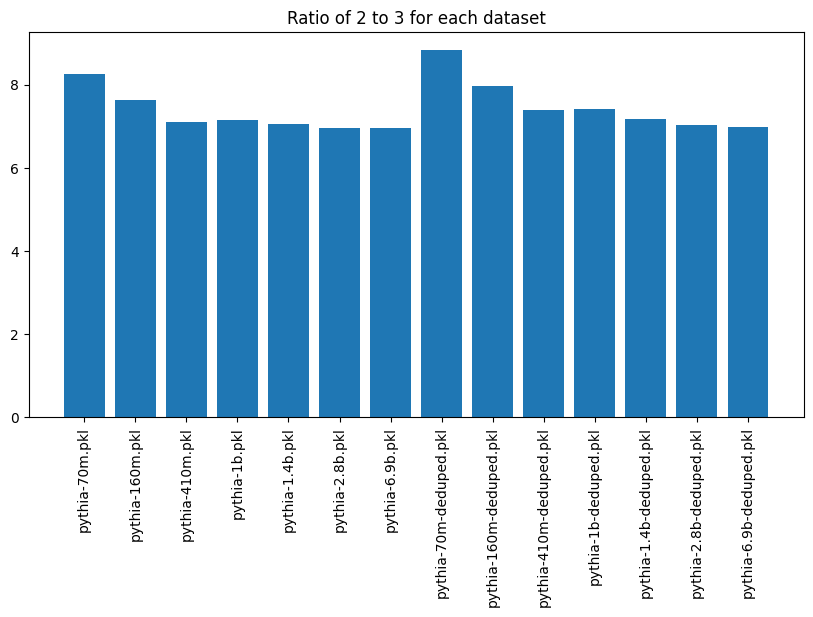

In [20]:
# plot ratio_2_3
plt.figure(figsize=(10, 5))
plt.bar(df_ratios['file'], df_ratios['ratio_2_3'])
# rotate xticks
plt.xticks(rotation=90)
plt.title('Ratio of 2 to 3 for each dataset')

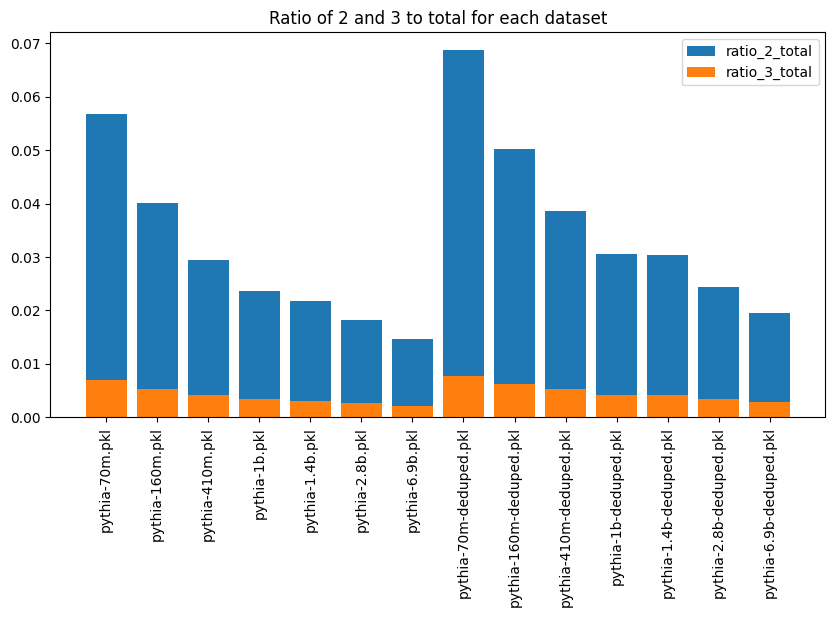

In [21]:
# plot ratio_2_total and ratio_3_total
plt.figure(figsize=(10, 5))
plt.bar(df_ratios['file'], df_ratios['ratio_2_total'], label='ratio_2_total')
plt.bar(df_ratios['file'], df_ratios['ratio_3_total'], label='ratio_3_total')
# rotate xticks
plt.xticks(rotation=90)
plt.title('Ratio of 2 and 3 to total for each dataset')
plt.legend()

Text(0.5, 1.0, 'Ratio of not memorized to total for each dataset')

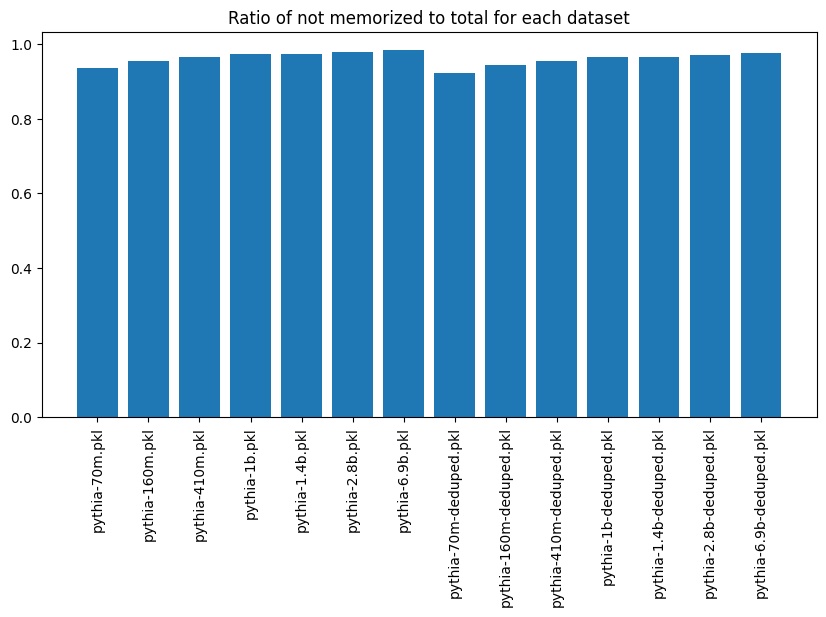

In [22]:
# plot ratio_not_memorized_total
plt.figure(figsize=(10, 5))
plt.bar(df_ratios['file'], df_ratios['ratio_not_memorized_total'])
# rotate xticks
plt.xticks(rotation=90)
plt.title('Ratio of not memorized to total for each dataset')

Text(0.5, 1.0, 'Count of memorized for each dataset')

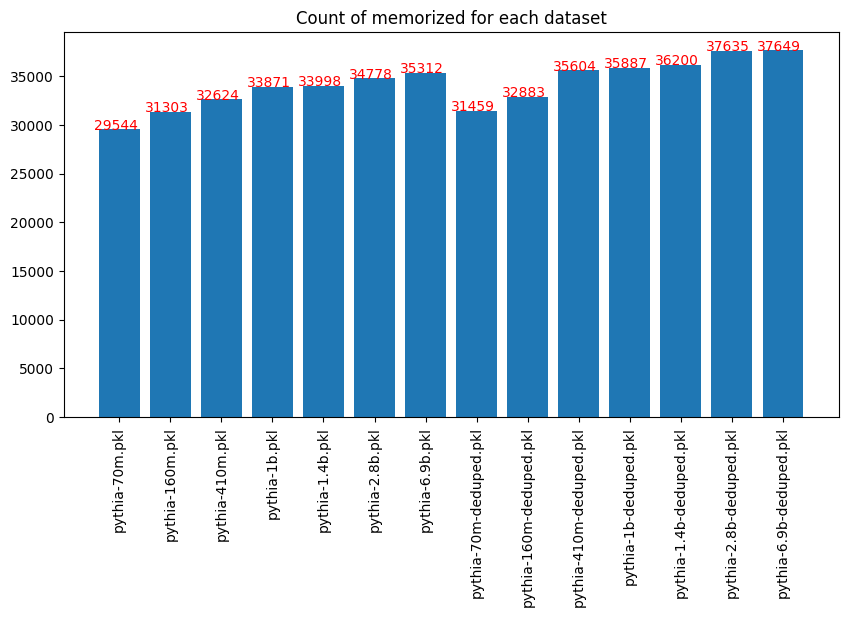

In [34]:
# plot count_memorized
plt.figure(figsize=(10, 5))
plt.bar(df_ratios['file'], df_ratios['count_memorized'])
# Add labels to bars
for i, v in enumerate(df_ratios['count_memorized']):
    plt.text(i-0.5, v+1.5, str(v), color='red')
# rotate xticks
plt.xticks(rotation=90)
plt.title('Count of memorized for each dataset')

In [23]:
df_ratios.to_csv('../data/exact_match_ratios.csv')

In [ ]:
# # Stitch together the plots into a pdf
# import glob
# from fpdf import FPDF
# from PIL import Image

# pdf = FPDF()
# # imagelist is the list with all image filenames
# files = glob.glob('../plots/*.png')
# # choose files with lrs in the name
# files = [file for file in files if 'chunk_length' in file]
# for image in files:
#     pdf.add_page()
#     pdf.image(image, 0, 0, 210, 220)
# pdf.output("../plots/exact_match.pdf", "F")

''